In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#per la rimozione degli outliers
from scipy import stats

#per la vecchia regressione
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

#dal notebook del professore
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

## Preproessing

In [2]:
df=pd.read_csv('train.csv', skipinitialspace=True)

In [3]:
df=df.drop(['features_duration_ms'], axis=1)

In [4]:
df['duration_ms'] = df['duration_ms'].apply(lambda x: x/1000)

In [5]:
#non faccio i round per avere dati più precisi per la regressione

In [6]:
df.isnull().sum()

name                         0
duration_ms                  0
explicit                     0
popularity                   0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                      4450
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
time_signature            2062
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [7]:
#provo a concentrarmi su time_signature e droppo le altre due colonne con nan

In [9]:
genres = sorted(df['genre'].unique())
genres_mapping = dict(zip(genres, range(0, len(genres) + 1)))
df['genres_val'] = df['genre'].map(genres_mapping).astype(int)

expl = sorted(df['explicit'].unique())
expl_mapping = dict(zip(expl, range(0, len(expl) + 1)))

df['explicit_val'] = df['explicit'].map(expl_mapping).astype(int)
df=df.drop(['name', 'explicit', 'artists','album_name', 'genre', 'mode', 'popularity_confidence'], axis=1)

### Rimozione degli outliers

In [11]:
# Select only numeric columns for z-score calculation (excluding non-numeric or string columns)
numeric_columns = df[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing']]

z_scores = np.abs(stats.zscore(numeric_columns))
threshold = 3  # Set a threshold for z-score (usually 2 to 3)

# Find outliers using z-score
outliers = (z_scores > threshold).any(axis=1)


df = df[~outliers]

### Divisione del dataset

In [12]:
test=df[df['time_signature'].isnull()]
train=df[~df['time_signature'].isnull()]

In [34]:
X_iniz=train[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing']]
y_iniz=train['time_signature']
X_test=test[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing']]
y_test=test['time_signature']

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_iniz, y_iniz, test_size=0.2, random_state=42)

In [38]:
y_val

6414     4.0
11009    4.0
2061     4.0
609      4.0
7898     4.0
        ... 
8519     4.0
500      4.0
8950     3.0
1489     4.0
6197     1.0
Name: time_signature, Length: 2328, dtype: float64

## Vecchia Regressione

In [18]:
regression_model = Ridge(alpha=0.5)

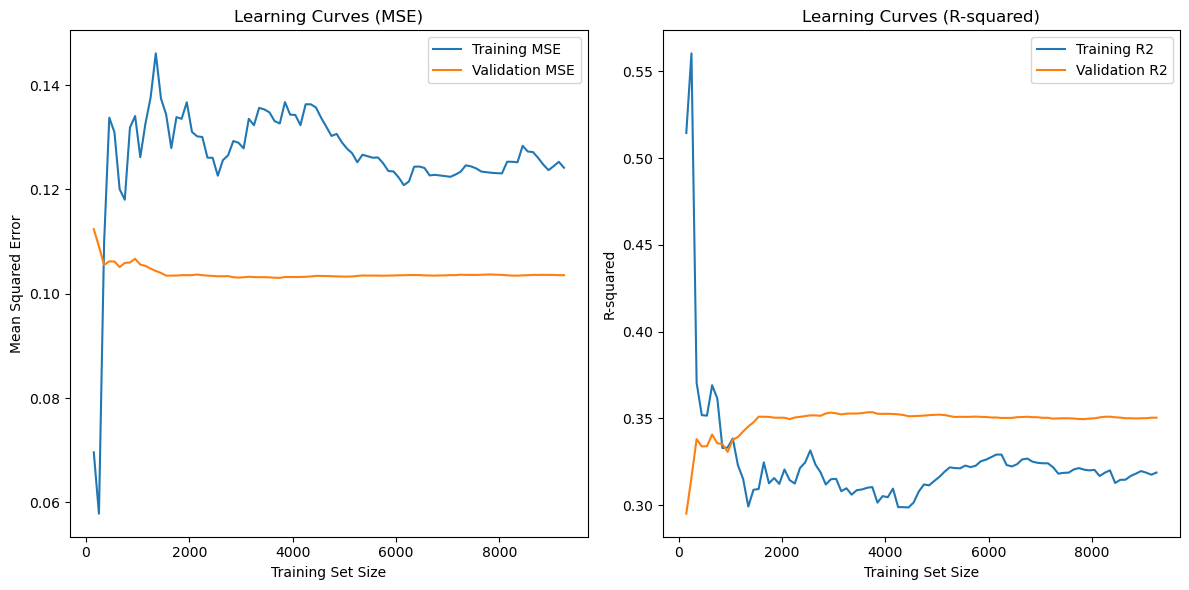

0.35041441837248355
0.10355956057755608


In [20]:
train_sizes, train_mse, val_mse, train_r2, val_r2 = [], [], [], [], []

for train_size in range(150, len(X_train), 100):  # You can adjust the step size
    X_subset, y_subset = X_train[:train_size], y_train[:train_size]
    
    regression_model.fit(X_subset, y_subset)
    
    # Make predictions on the validation set
    y_val_pred = regression_model.predict(X_val)
    
    # Calculate validation MSE and R-squared
    val_mse_value = mean_squared_error(y_val, y_val_pred)
    val_r2_value = r2_score(y_val, y_val_pred)
    
    train_sizes.append(train_size)
    train_mse.append(mean_squared_error(y_subset, regression_model.predict(X_subset)))
    val_mse.append(val_mse_value)
    train_r2.append(r2_score(y_subset, regression_model.predict(X_subset)))
    val_r2.append(val_r2_value)

# Plot learning curves for MSE and R-squared
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mse, label='Training MSE')
plt.plot(train_sizes, val_mse, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Learning Curves (MSE)')

# Plot R-squared
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_r2, label='Training R2')
plt.plot(train_sizes, val_r2, label='Validation R2')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared')
plt.legend()
plt.title('Learning Curves (R-squared)')

plt.tight_layout()
plt.show()

print(val_r2_value)
print(val_mse_value)

In [23]:
# Model selection and training
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predict null values
predicted_values = regression_model.predict(X_test)

# Replace null values with predicted values
df.loc[df['time_signature'].isnull(), 'time_signature'] = predicted_values

# Model evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

regression_model.fit(X_train, y_train)
y_val_pred = regression_model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Squared Error on Validation Data: {mse}")
print(f"Root Mean Squared Error on Validation Data: {rmse}")
print(f"R-squared on Validation Data: {r2}")

Mean Squared Error on Validation Data: 0.1158053286092801
Root Mean Squared Error on Validation Data: 0.34030181987359415
R-squared on Validation Data: 0.33016881702807943


In [33]:
y_pred = regression_model.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.350
MSE: 0.104
MAE: 0.107


## Decision tree

In [47]:
#df_val=df[df["time_signature"].isin(y_val.values)]

In [53]:
reg = DecisionTreeRegressor()

In [54]:
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [56]:
y_pred = reg.predict(X_val)
print('R2: %.3f' % r2_score(y_val, y_pred))
print('MSE: %.3f' % mean_squared_error(y_val, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_val, y_pred))

R2: -0.832
MSE: 0.292
MAE: 0.157


In [66]:
from sklearn.model_selection import GridSearchCV

# Definisci l'albero decisionale
decision_tree = DecisionTreeRegressor()

# Definisci i parametri che desideri ottimizzare
parametri = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crea un oggetto GridSearchCV
grid_search = GridSearchCV(decision_tree, parametri, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Esegui la ricerca degli iperparametri sul training set
grid_search.fit(X_train, y_train)

# Stampa i migliori parametri e il miglior punteggio
print("Migliori parametri:", grid_search.best_params_)
print("Miglior punteggio:", -grid_search.best_score_)

# Fai predizioni sul test set utilizzando il modello con i migliori parametri
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Valuta le prestazioni del modello, ad esempio, calcolando l'errore quadratico medio (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f"Errore quadratico medio (MSE) sul test set: {mse}")

Migliori parametri: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Miglior punteggio: 0.18200613423236595
Errore quadratico medio (MSE) sul test set: 0.14888746909480507


In [67]:
print('R2: %.3f' % r2_score(y_val, y_pred))
print('MSE: %.3f' % mean_squared_error(y_val, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_val, y_pred))

R2: 0.066
MSE: 0.149
MAE: 0.164


## Knn

In [61]:
k_values = list(range(1, 21))

from sklearn.model_selection import cross_val_score

results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -scores.mean()  # Poiché vogliamo massimizzare il punteggio, invertiamo il segno
    results.append((k, mean_score))
    
best_k = min(results, key=lambda x: x[1])[0]
print(f"Il miglior valore di k è: {best_k}")

Il miglior valore di k è: 11


In [62]:
reg = KNeighborsRegressor(n_neighbors=11)

In [63]:
reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=11)

In [64]:
y_pred = reg.predict(X_val)
print('R2: %.3f' % r2_score(y_val, y_pred))
print('MSE: %.3f' % mean_squared_error(y_val, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_val, y_pred))

R2: 0.299
MSE: 0.112
MAE: 0.097
